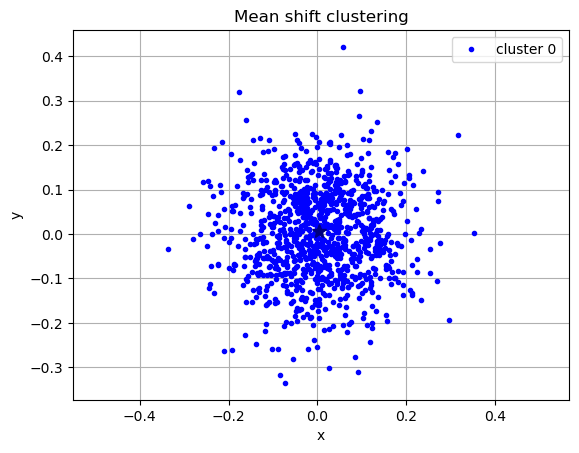

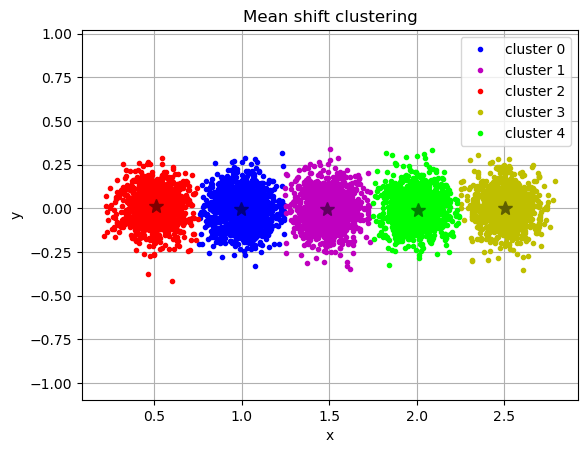

In [3]:
import matplotlib.pyplot as plt

from clustering_utils import gaussian_cluster, draw_clusters, distance, gauss_core
from typing import Union, List, Tuple
import numpy as np


class MShift:
    def __init__(self):
        """
        Метод среднего сдвига.
        Этапы алгоритма:
        1. Копируем переданные данные для кластеризации "data" в "data_shifted"
        2. Для каждой точки из набора данных "data" с индексом "point_index" считаем среднее значение вокруг нее.
        3. Полученное значение на среднего сравниваем со значением под индексом "point_index" из "data_shifted"
           Если расстояние между точками меньше, чем некоторый порог "distance_threshold", то говорим, что смещать
           точку далее нет смысла и помечаем ее, как неподвижную.
           Для новой неподвижной точки пытаемся найти ближайший к ней центр кластера и добавить индекс этой точки
           к индексам точек кластера. Кластер считается ближайшим, если расстояние между точкой и центроидом
           меньше, чем "window_size".
           Если такового нет, то точка считается новым центром кластера.
        4. Пункты 2-3 повторяются до тех пор, пока все точки не будут помечены, как неподвижные.
        """
        """
        Количество кластеров, которые ожидаем обнаружить.
        """
        self._n_clusters: int = -1
        """
        Данные для кластеризации. Поле инициализируется при вызове метода fit.
        Например, если данные представляют собой координаты на плоскости,
        каждая отельная строка - это точка этой плоскости.
        """
        self._data: Union[np.ndarray, None] = None
        """
        Центры кластеров на текущем этапе кластеризации.
        """
        self._clusters_centers: Union[List[np.ndarray], None] = None
        """
        Список индексов строк из "_data", которые соответствуют определённому кластеру.
        Список списков индексов.
        """
        self._clusters_points_indices: Union[List[List[int]], None] = None
        """
        Расстояние между центроидом кластера на текущем шаге и предыдущем при котором завершается кластеризация.
        """
        self._distance_threshold: float = 1e-3
        """
        Ширина ядра функции усреднения.
        """
        self._window_size: float = 0.15

    @property
    def window_size(self) -> float:
        """
        Просто геттер для ширины ядра функции усреднения ("_window_size").
        """
        return self._window_size

    @window_size.setter
    def window_size(self, value: float) -> None:
        """
        Сеттер для ширины ядра функции усреднения ("_window_size").
        1. Должен осуществлять проверку типа.
        2. Проверку на не отрицательность.
        """
        assert isinstance(value, float), f"ВАЛУЕ НЕ ФЛОАТ {value}"
        assert value >= 0.0, f"ВАЛУЕ МЕНЬШЕ 0 {value}"
        self._window_size = value

    @property
    def distance_threshold(self) -> float:
        """
        Просто геттер для "_distance_threshold".
        """
        return self._distance_threshold

    @distance_threshold.setter
    def distance_threshold(self, value: float) -> None:
        """
        Сеттер для "_distance_threshold".
        1. Должен осуществлять проверку типа.
        2. Проверку на не отрицательность.
        """
        assert isinstance(value, float), f"ВАЛУЕ НЕ ФЛОАТ {value}"
        assert value >= 0.0, f"ВАЛУЕ МЕНЬШЕ 0 {value}"
        self._distance_threshold = value

    @property
    def n_clusters(self) -> int:
        """
        Геттер для числа кластеров, которые обнаружили.
        """
        return 0 if self._clusters_centers is None else len(self._clusters_centers)

    @property
    def n_samples(self) -> int:
        """
        Количество записей в массиве данных. Например, количество {x, y} координат на плоскости.
        """
        return self._data.shape[0] if self._data is not None else 0

    @property
    def n_features(self) -> int:
        """
        Количество особенностей каждой записи в массив денных. Например,
        две координаты "x" и "y" в случе точек на плоскости.
        """
        return self._data.shape[1] if self._data is not None else 0

    @property
    def clusters(self) -> List[np.ndarray]:
        """
        Создаёт список из np.ndarray. Каждый такой массив - это все точки определённого кластера.
        Индексы точек соответствующих кластеру хранятся в "_clusters_points_indices"
        """
        if self._data is None:
            return []
        
        return [np.array([self._data[cluster_point_idx, :] for cluster_point_idx in cluster_indexes]) for cluster_indexes in self._clusters_points_indices]
    
    def _clear_current_clusters(self) -> None:
        """
        Очищает центры кластеров на текущем этапе кластеризации.
        Очищает список индексов строк из "_data", которые соответствуют определённому кластеру.
        Реализует "ленивую" инициализацию полей "_clusters" и "_clusters_centers".
        """
        self._clusters_points_indices = self._clusters_points_indices or []
        self._clusters_centers = self._clusters_centers or []
        self._clusters_points_indices.clear()
        self._clusters_centers.clear()

    def _shift_cluster_point(self, point: np.ndarray) -> np.ndarray:
        """
        Функция, которая считает средне-взвешенное (если, например, используется Гауссово ядро) внутри круглого окна
        с радиусом "window_size" вокруг точки point. Реализуем формулу (Σw_i*x_i) / Σw_i
        Возвращает массив, равный по размеру "point".
        """
        distances = np.linalg.norm(self._data - point, axis=1)
        weights = gauss_core(distances, self.window_size)
        weighted_data = self._data * weights[:, np.newaxis]
        return np.sum(weighted_data, axis=0) / np.sum(weights)

    def _update_clusters_centers(self, sample_index, sample: np.ndarray):
        """
        Функция ищет ближайший центр кластера для точки "sample".
        Если не находит, то считает, что "sample" - новый центр кластера.
        Если находит, то добавляет к индексам точек кластера "sample_index"
        """
        if self.n_clusters == 0:
            self._clusters_centers.append(sample)
            self._clusters_points_indices.append([sample_index])
        else:
            cluster_index, cluster_distance = self._get_closest_cluster_center(sample)
            if cluster_distance < self._window_size:
                self._clusters_points_indices[cluster_index].append(sample_index)
            else:
                self._clusters_centers.append(sample)
                self._clusters_points_indices.append([sample_index])

    def _shift_cluster_points(self) -> None:
        """
        Выполняет итеративный сдвиг всех точек к их среднему значению.
        Т.е. для каждой точки вызывается функция _shift_cluster_point()
        Выполняется до тех пор, пока все точки не будут помечены, как неподвижные.
        """
        shifted_data = np.array(self._data)
        still_shifting = np.ones(self.n_samples, dtype=bool)
        frozen_count = 0
        while frozen_count != self.n_samples:
            for index, point in enumerate(shifted_data):
                if not still_shifting[index]:
                    continue
                new_point = self._shift_cluster_point(point)
                dist = distance(point, new_point)
                shifted_data[index] = new_point
                if dist > self.distance_threshold:
                    continue
                frozen_count += 1
                still_shifting[index] = False
                self._update_clusters_centers(index, new_point)

    def _get_closest_cluster_center(self, sample: np.ndarray) -> Tuple[int, float]:
        """
        Определяет ближайший центр кластера для точки из переданного набора данных и расстояние до него.
        Hint: для ускорения кода используйте min с генератором.
        """
        min_distance = float('inf')
        min_index = None

        for cluster_index, cluster_center in enumerate(self._clusters_centers):
            current_distance = distance(cluster_center, sample)
            if current_distance < min_distance:
                min_distance = current_distance
                min_index = cluster_index

        return min_index, min_distance

    def fit(self, data: np.ndarray) -> None:
        """
        Выполняет кластеризацию данных в "data".
        1. Необходима проверка, что "data" - экземпляр класса "np.ndarray".
        2. Необходима проверка, что "data" - двумерный массив.
        Этапы работы метода:
        # 1. Проверки передаваемых аргументов
        # 2. Присваивание аргументов внутренним полям класса.
        # 3. Сдвиг точек в направлении средних значений вокруг них ("_shift_cluster_points").
        """
        assert isinstance(data, np.ndarray) and data.ndim == 2, "Загрузите данные в правильном формате"
        self._data = data
        self._clear_current_clusters()
        self._shift_cluster_points()

    def show(self):
        draw_clusters(self.clusters, cluster_centers=self._clusters_centers, title="Mean shift clustering")


def separated_clusters():
    """
    Пример с пятью разрозненными распределениями точек на плоскости.
    """
    m_means = MShift()
    clusters_data = np.vstack((gaussian_cluster(cx=0.5, n_points=1024),
                               gaussian_cluster(cx=1.0, n_points=1024),
                               gaussian_cluster(cx=1.5, n_points=1024),
                               gaussian_cluster(cx=2.0, n_points=1024),
                               gaussian_cluster(cx=2.5, n_points=1024)))
    m_means.fit(clusters_data)
    m_means.show()


def merged_clusters():
    """
    Пример с кластеризацией пятна.
    """
    m_means = MShift()
    m_means.fit(gaussian_cluster(n_points=1024))
    m_means.show()


if __name__ == "__main__":
    """
    Сюрприз-сюрприз! Вызов функций "merged_clusters" и "separated_clusters".
    """
    try:
        merged_clusters()
        separated_clusters()
    except AssertionError as e:
        print(f"Произошла ошибка: {e}")
